#PRACTICAL SESSION 4

**PART I: K-means++**

STEP 1: Importing the libraries

In [2]:
# Important libraries
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
import math

STEP 2: Defining a class to create usable data

In [3]:
class Data:
  
  def __init__(self,fileName):
    self.loadData(fileName)
    color = self.y@np.arange(1, self.y.shape[1]+1, 1, dtype=int).T
    self.color = color

  def loadData(self,fileName):
    # Uses a csv file to create a numpy array
    with open(fileName, newline='') as csvfile:
      reader = csv.reader(csvfile, delimiter=',', quotechar='|')
      data = list(reader)
    data = np.array(data)
    self.X = np.array(data[1:np.shape(data)[0],0:-1],dtype='float64')  
    ydata = np.array(data[1:np.shape(data)[0],-1],dtype='int32')
    self.y = np.zeros((len(ydata),np.amax(ydata)-np.amin(ydata)+1))
    for i in range(self.y.shape[0]):
      for j in range(self.y.shape[1]):
        if ydata[i] == j+1:
            self.y[i,j] = 1

  def SplitData(self,testRatio):
    # Shuffles the data and splits data in train and test 
    M      = self.X.shape[0]
    ntrain = int((1-testRatio)*M) 
    idx    = np.arange(M)
    np.random.shuffle(idx) 
    self.Xtrain = self.X[idx[0:ntrain],:]
    self.Xtest  = self.X[idx[ntrain:M],:]
    self.Ytrain = self.y[idx[0:ntrain],:]
    self.Ytest  = self.y[idx[ntrain:M],:]

  def plotCorrelationMatrix(self):
    # Plots the variables two by two in matrix of correlation
    nF = self.X.shape[1]
    figure, axes = plt.subplots(nrows=nF, ncols=nF)
    plt.gcf().set_size_inches(10, 8)
    for i in range(nF):
      for j in range(nF):
        if i == j:
          axes[i,j].hist(self.X[:,j])
        else:
          axes[i,j].scatter(self.X[:,j],self.X[:,i],c=self.color,cmap=cm.brg)
    plt.show()  

  def plotData(self,i,j):
    # Plots Xi vs Xj
    plt.scatter(self.X[:,i],self.X[:,j],c=self.color,cmap=cm.brg)

def testAccuracy(Z,Y):
  cont = 0
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if Z[i,j] == np.amax(Z[i,:]):
        p = j
      if Y[i,j] == np.amax(Y[i,:]):
        t = j
    if p == t:
      cont += 1 
  TA = cont/Y.shape[0]
  return TA

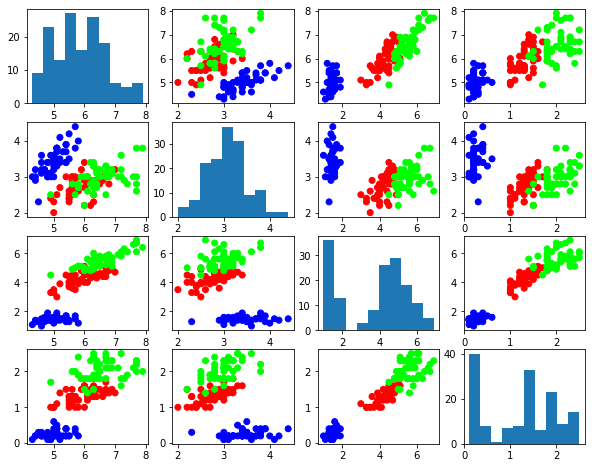

In [6]:
data = Data('P4_kmeans_iris.csv')
data.SplitData(0.2)
data.plotCorrelationMatrix()
Xtr = data.Xtrain[:,[0,2]]
Ytr = data.Ytrain
Xte = data.Xtest[:,[0,2]]
Yte = data.Ytest

STEP 3: Define the Kmeans algorithm

In [18]:
# Define a function that given a matrix of points X, and its assignments Z computes the centroids of the clusters
def centroids(X,Z,k):
  mu = Z.T@X
  n = np.sum(Z,axis=0,keepdims=True).T
  mu = mu/n
  return mu

# Define a function that given a matrix of data X and a vector of centroids mu, assigns each point of X to one cluster
def cluster_assig(X,mu,k):
  nD = X.shape[0]
  Z  = np.zeros((X.shape[0],k))
  aux1 = np.zeros((X.shape[0],k))
  for i in range(k):
    aux2 = np.zeros((X.shape[0],k))
    aux2[:,i] = 1
    aux1[:,i] = np.sum((X-aux2@mu)**2,axis=1)
  I = np.argmin(aux1,axis=1)
  for n in range(nD):
    for i in range(k):
      if i == I[n]:
        Z[n,i] = 1
        break
  return Z

# Define a function that given the number of clusters wanted and the matrix of points X, uses the kmeans++ 
# initialization technique to compute the initial centroids
def plusplusInitialization(X,k):
  nD = X.shape[0]
  nF = X.shape[1]
  mu = np.zeros((k,nF))
  a  = np.random.randint(nD,size=1)
  mu[0,:] = X[a,:]
  X = np.delete(X,a,0)
  for i in range(1,k):
    distance = np.sum((X-mu[i-1,:])**2,axis=1)
    distance = distance/np.max(distance,axis=0)
    C = np.cumsum(distance)
    f_ = np.sum(np.random.uniform(0,1)>C)
    mu[i,:] = X[f_,:]
    X = np.delete(X,f_,0)
  return mu

# Using the previous functions, create one that iterates and updates the centroids
def kmeans(X,k):
  err = []
  delta = 1
  mu0 = plusplusInitialization(X,k)
  Z = cluster_assig(X,mu0,k)
  mu_old = mu0
  while delta > 10**(-6):
    mu_new = centroids(X,Z,k)
    Z      = cluster_assig(X,mu_new,k)
    delta  = np.amax(np.amax(np.abs(mu_new-mu_old),axis=1))
    err.append(np.mean(np.sum((X-Z@mu_new)**2,axis=1)))
    mu_old = mu_new
  return mu_new,err,mu0

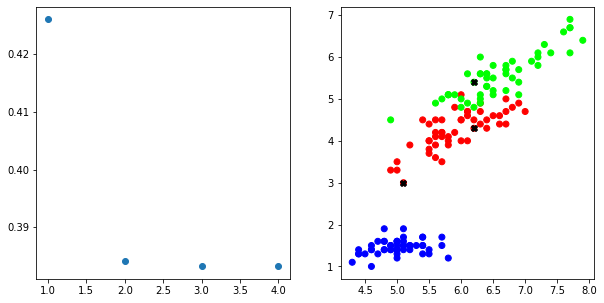

In [33]:
k = 3
mu,err,mu0 = kmeans(Xtr,k)
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.scatter(np.arange(1,len(err)+1),err)
plt.subplot(1,2,2)
data.plotData(0,2)
plt.scatter(mu0[:,0],mu0[:,1],color="black",marker="X")
plt.show()

In [42]:
# Use this line to swap rows on mu until matching the true labels
mu[[0,1,2],:] = mu[[0,2,1],:]

Train accuracy =  0.2605042016806723

Test accuracy =  0.23333333333333334


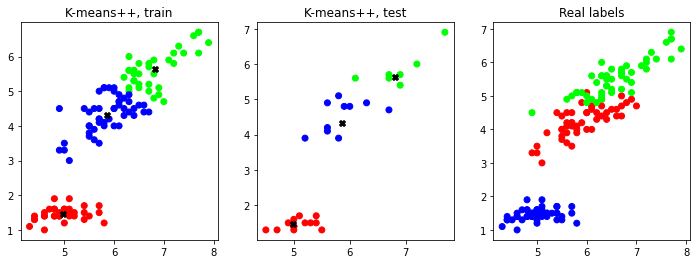

In [12]:
Z   = cluster_assig(Xtr,mu,k)
Zte = cluster_assig(Xte,mu,k)
color = Z@np.arange(1, Z.shape[1]+1, 1, dtype=int).T
colorte = Zte@np.arange(1, Z.shape[1]+1, 1, dtype=int).T
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title('K-means++, train')
plt.scatter(Xtr[:,0],Xtr[:,1],c=color,cmap=cm.brg)
plt.scatter(mu[:,0],mu[:,1],color="black",marker="X")

plt.subplot(1,3,2)
plt.title('K-means++, test')
plt.scatter(Xte[:,0],Xte[:,1],c=colorte,cmap=cm.brg)
plt.scatter(mu[:,0],mu[:,1],color="black",marker="X")

plt.subplot(1,3,3)
plt.title('Real labels')
data.plotData(0,2)
TA = testAccuracy(Z,Ytr)
TAe = testAccuracy(Zte,Yte)

print('Train accuracy = ',TA)
print('\nTest accuracy = ',TAe)
plt.show()

**PART II: PCA**

STEP 4: Use svd to make a scree plot and a cumulative energy plot


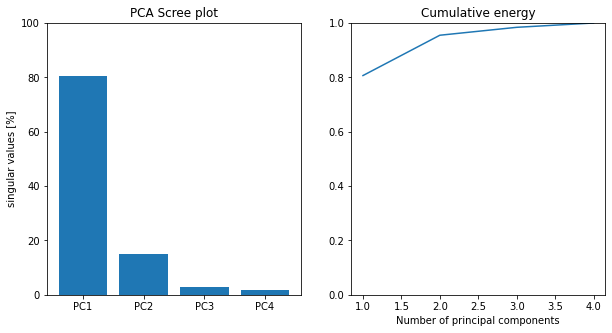

In [13]:
# Using the same data, use np.linalg.svd() to do obtain u,s,v and plot the results
X = data.X
u,s,v = np.linalg.svd(X, full_matrices=False)
rc = s/np.sum(s)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(['PC1','PC2','PC3','PC4'],rc*100)
plt.title("PCA Scree plot")
plt.ylabel("singular values [%]")
plt.ylim((0,100))
plt.subplot(1,2,2)
plt.plot(np.arange(1,5),np.cumsum(rc))
plt.title("Cumulative energy")
plt.xlabel("Number of principal components")
plt.xlabel("Number of principal components")
plt.ylim((0,1))
plt.show()

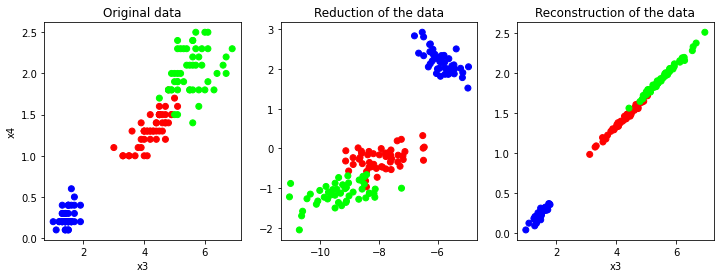

In [14]:
# Develop a script to plot the data in the reducted dimension and plot 
# the reconstruction after cuting the information
s_aux = np.diag(s)
r = 2
X_l = (u[:,0:r]@s_aux[0:r,0:r]@v[0:r,:])
T = u[:,0:r]@s_aux[0:r,0:r]

colorPCA = data.y@np.arange(1, data.y.shape[1]+1, 1, dtype=int).T
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Original data')
plt.xlabel('x3')
plt.ylabel('x4')
plt.scatter(X[:,2],X[:,3],c=colorPCA,cmap=cm.brg)
plt.subplot(1,3,2)
plt.title('Reduction of the data')
plt.scatter(T[:,0],T[:,1],c=colorPCA,cmap=cm.brg)
plt.subplot(1,3,3)
plt.title('Reconstruction of the data')
plt.xlabel('x3')
plt.scatter(X_l[:,2],X_l[:,3],c=colorPCA,cmap=cm.brg)
plt.show()

STEP 5: PCA for dimensionality reduction in images

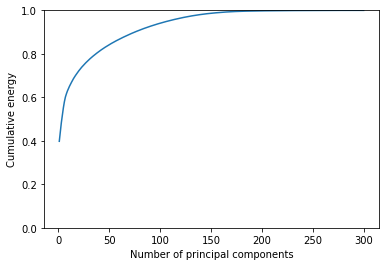

In [15]:
from matplotlib import image

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = image.imread('giraffe.jpg')
g = rgb2gray(img)    
G = np.array(g)
u,s,v = np.linalg.svd(G, full_matrices=False)
rc = s/np.sum(s)
plt.plot(np.arange(1,len(rc)+1),np.cumsum(rc))
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative energy")
plt.ylim((0,1))
plt.show()

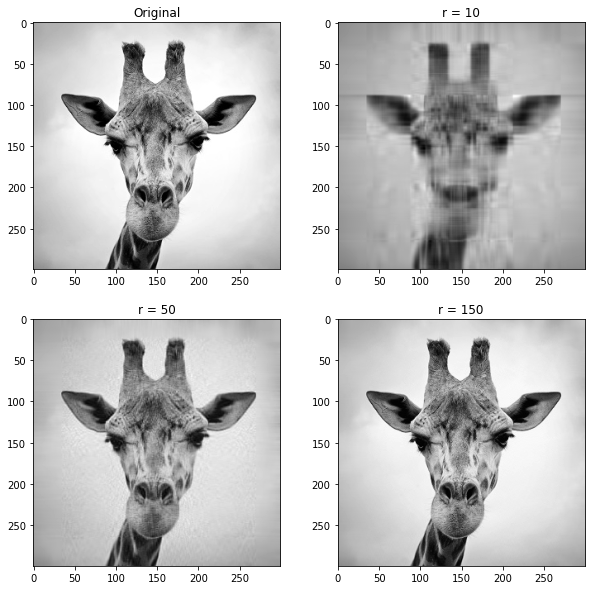

In [16]:
# Plot the image with different values of truncation and see the results
s_aux = np.diag(s)
r = [10,50,150]
X_g = []
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(G,cmap='gray')
plt.title('Original')
for i in range(len(r)):
  X_g.append((u[:,0:r[i]]@s_aux[0:r[i],0:r[i]]@v[0:r[i],:]))
  plt.subplot(2,2,i+2)
  plt.imshow(X_g[i],cmap='gray')
  plt.title('r = ' + str(r[i]))
plt.show()